## Read Data

In [1]:
import warnings
warnings.filterwarnings("ignore")

import re
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

In [2]:
df = pd.read_csv('./train.csv')
col = list(df.columns)
df['length'] = df.comment_text.apply(lambda x : len(x))
df = df[col[:2]+ ['length'] + col[2:]]
df.head()

,id,comment_text,length,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,264,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,112,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",233,0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",622,0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",67,0,0,0,0,0,0


In [3]:
print(df.describe().loc['mean'].iloc[1:]*100)

toxic            9.584448
severe_toxic     0.999555
obscene          5.294822
threat           0.299553
insult           4.936361
identity_hate    0.880486
Name: mean, dtype: float64


<hr/>
기본적으로 데이터를 살펴보면, 각 클레스는 대략적으로 10% 미만으로 1로 라벨링이 된 것을 확인할 수 있다.  
모든 클래스에 대해서 데이터의 불균형이 심한 상태이다.  
Imbalance를 고려하여 Loss에 가중치를 주어서 트레이닝 시킨다.  
기본적인 cross-entropy Loss 에서 label 이 1일 때의 가중치(w>=1)를 주어 Recall을 증가시킬 수 있도록 하자.  
여러 가중치를 실험해본다.

기본적인 전략은 각 클래스별로 모델을 학습시켜 Classify 하는 것이다.  
다음과 같은 방법을 적용하여 문제를 해결해 볼 것이다.


    1. Sentence embedding -> dense network 
        1-1 : LSTM 
        1-2 : Conv
        
    2. Attention Layer로 구성한 Model을 통해 각각의 클래스 마다 모델을 만들어 예측하는 전략을 취한다.     
    3. SVM
    4. Decision Tree / Random forest
    5. Ensenble
<hr/>

In [4]:
print(len(df[(df.toxic == 1) & (df.severe_toxic == 0)]))
print(len(df[(df.toxic == 1) & (df.severe_toxic == 1)]))
print(len(df[(df.toxic == 0) & (df.severe_toxic == 1)]))

13699
1595
0


이때 severe_toxic class는 항상 toxic class인 경우에만 성립하므로  
toxic을 classify한 이후에 severe_toxic class를 classify 하도록 training 한다. 

## Text Preprocessing

### Stemming 

같은 의미의 단어이되 인칭의 변화 등 문법적인 이유로 형태가 다른 단어들을 같은 형태로 변환시켜준다.  
여기에는 대문자를 소문자로 바꾸는 것도 포함된다. 

In [5]:
stemmer = nltk.stem.SnowballStemmer('english')

In [6]:
df['comment_text'] = df.comment_text.apply(lambda text: ' '.join(map(lambda word: stemmer.stem(word), re.split(' |\n', text))))

In [8]:
df.head()

,id,comment_text,length,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explan whi the edit made under my usernam hard...,264,0,0,0,0,0,0
1,000103f0d9cfb60f,d'aww! he match this background colour i'm see...,112,0,0,0,0,0,0
2,000113f07ec002fd,"hey man, i'm realli not tri to edit war. it ju...",233,0,0,0,0,0,0
3,0001b41b1c6bb37e,""" more i can't make ani real suggest on improv...",622,0,0,0,0,0,0
4,0001d958c54c6e35,"you, sir, are my hero. ani chanc you rememb wh...",67,0,0,0,0,0,0


## 1. Method of RNN

현재 사용된 샘플에서의 feature의 수(# of voca)가 매우 많기 때문에 임베딩이 필요하다.  
다음과 같은 두가지 방법을 이용하여 접근하여 보자.

> 1. Embedding layer를 포함한 Model을 Training 
> 2. Word2Vec을 이용한 Pretrained embedding layer를 사용하여 Training 

In [11]:
print('# of voca: {}'.format(len(set([word for doc in df.comment_text for word in doc.split(' ')]))))

# of voca: 420953


RNN 구조는 길이가 지나치게 긴 문장에 대해 Backpropagation이 잘 이루어지지 않으므로, 문장 길이를 제한한다.  
문장길이의 분포를 살펴보면, 대부분이 1000자 이하의 글자로 구성되어 있으므로 1000자 이하의 표본을 이용하여 학습시킨다.

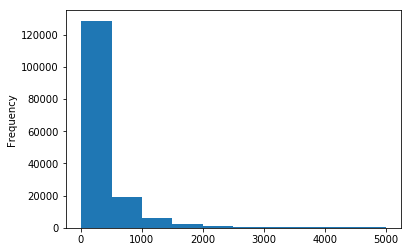

In [10]:
df.length.plot.hist()

In [7]:
print('length <= 1000 : {}'.format(sum(df.length<=1000)))
print('length >  1000 : {}'.format(sum(df.length>1000)))

length <= 1000 : 146211
length >  1000 : 13360


In [8]:
df = df[df.length<=1000]

평균적으로 한 Document 당 vocab의 분포와 평균적인 개수는 다음과 같다.  
RNN의 Batch sequence length를 200으로 설정하고 Dataset을 구성한다.

평균적인 vocab의 숫자 : 70.39


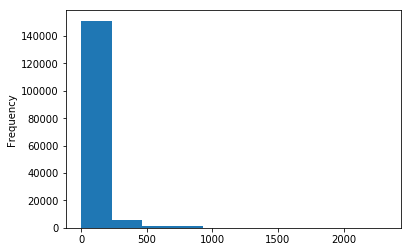

In [36]:
df.comment_text.apply(lambda txt: len(txt.split(' '))).plot.hist()
print('평균적인 vocab의 숫자 : {:.2f}'.format(np.mean(df.comment_text.apply(lambda txt: len(txt.split(' '))))))

### Without Word2Vec

In [37]:
max_length =  200

In [70]:
voca_list = list(set([corpus.lower() for list_ in df.comment_text.apply(lambda x : x.split('\n')) for line in list_ for corpus in line.split()]))
voca2int = {voca: idx for idx, voca in zip(voca_list, range(1, len(voca_list) + 1 ))}
int2voca = {idx: voca for idx, voca in zip(voca_list, range(1, len(voca_list) + 1 ))}
voca2int['<pad>'] = 0
int2voca[0] = '<pad>'

In [8]:
class Hparam(object):
    def __init__(self):
        self.vocab_size = len(int2voca)
        self.embedding_size = 100
        self.rnn_unit_1 = 128
        self.rnn_unit_2 = 256
        self.dense_unit = 128
        self.init_learning_rate = 0.01

hparam = Hparam()

NameError: name 'int2voca' is not defined

In [1]:
def Model(object):
    def __init__(self, inputs, labels, eval_inputs, eval_labels, data_init, hparam):
        
        self.inputs = inputs
        self.labels = labels
        self.data_init = data_init

        self.vocab_size = hparam.vocab_size
        self.embedding_size = hparam.embedding_size
        self.rnn_unit_1 = hparam.rnn_unit_1
        self.rnn_unit_2 = hparam.rnn_unit_2
        self.dense_unit = hparam.dense_unit
        self.init_learning_rate = hparam.init_learning_rate
        
        self._build()
        self._init_step_and_epoch()
        self._init_saver()
        
    def _build():
        """Build tensorflow graph"""
        
        # 2-D tensor [B, T] inputs
        with tf.variable_scope('Embed'):
            
            embed = tf.contrib.layers.embed_sequence(ids=self.inputs,
                                                     vocab_size=self.vocab_size, 
                                                     embed_dim=embedding_size)
            
        # now 3-D tensor [B, T, C]
        with tf.variable_scope('RNN'):
            rnn_layers = [tf.contrib.rnn.BasicLSTMCell(size, activation=tf.nn.sigmoid) for size in [self.rnn_unit_1, self.rnn_unit2]]
            self.cell = tf.nn.rnn_cell.DropoutWrapper(tf.nn.rnn_cell.MultiRNNCell(rnn_layers))
            _, state = tf.nn.dynamic_rnn(cell=cell, inputs=embed)
                    
        with tf.variable_scope('Dense'):
            layer1= tf.layers.batch_normalization(tf.layers.dense(state,self.dense_unit, activation=tf.nn.sigmoid))
            self.logits = tf.layers.dense(layer1, 2, activation=None)
            
        self.learning_rate = tf.train.exponential_decay(self.init_learning_rate, 
                                                        self.global_step, 
                                                        decay_steps=1000, 
                                                        decay_rate=0.9)
        
        self.loss = tf.reduce_mean(tf.nn.weighted_cross_entropy_with_logits(targets=tf.one_hot(self.labels, depth=2), 
                                                                            logits=self.logits, 
                                                                            pos_weight=3.0))
        
        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate)
        
        gvs = self.optimizer.compute_gradients(self.loss, 
                                               tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES))
        
        cliped_grad = [(tf.clip_by_value(grad, -1.,1.), var) for grad, var in gvs]
        self.train_op = self.optimizer.apply_gradient(cliped_grad, global_step = self.global_step)
        
        
        self.prediction = tf.argmax(self.logits, axis=-1)    
        self.accuracy = tf.reduce_mean(tf.equal(self.prediction, self.labels), name='accuracy')
        
        # metrics : [Loss, accuracy]
        tf.summary.scalar(self.accuracy)
        tf.summary.scalar(self.loss)
        self.merge = tf.summary.merge_all()
        
    def _init_saver():
        self.saver = tf.train.Saver(var_list=tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES))
        
    def _init_step_and_epoch():
        self.global_step = tf.get_variable('global_step', initializer=tf.constant_initializer(0))
        self.epoch = tf.get_variable('epoch', initializer=tf.constant_initializer(0))
        
    def train(self, sess, epoch):
        sess.run([tf.global_variables_initializer(), self.data_init])
        
        while(1):
            try:
                sess.run(self.train_op)

            except tf.errors.OutOfRangeError:
                self.epoch = tf.add(self.epoch, 1)
                sess.run([self.data_init, self.merge])

    def evaluate(self, sess):
        pass
    
    def predict(self, inputs):
        pass
    
    def save():
        saver.save(sess, './ckpt/{}_epoch'.format(e)) 
        print('Graph is saved')
    
    def load():
        self.saver.restore(sess, tf.train.latest_checkpoint('./ckpt'))    
        print('Graph is loaded')

이때 구글에서 미리 트레이닝시켜 놓은 word2vec을 이용하여 300차원으로 Embedding 시킨다.  
이 후에 LSTM cell을 이용한 RNN 을 이용하여 문장을 Encoding 시킨 후 Dense network를 이용하여 Classify 해보자.